In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %pip install -q torchvision pandas
# %matplotlib inline

In [3]:
from charts.common.dataset import LabeledImage
from charts.common.timer import Timer
import charts.pytorch.color_regression as cr
import charts.pytorch.utils as utils
from charts.pytorch.utils import Experiment, num_trainable_parameters, is_google_colab

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

from torchvision.utils import make_grid
from torchvision.io import read_image
from torchvision.transforms import ToTensor, ToPILImage
from torchvision import transforms

import torch_lr_finder
import timm
from ptflops import get_model_complexity_info

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from PIL import Image

from icecream import ic
from tqdm.notebook import tqdm

import os
from pathlib import Path
import time
import random

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
display(f"Use CUDA: {use_cuda}")

'Use CUDA: True'

In [19]:
preprocessor = cr.ImagePreprocessor(device, target_size=128)

dataset_path = Path("/content/datasets/drawings") if is_google_colab() else Path('../../generated/drawings')

dataset = cr.ColorRegressionImageDataset(dataset_path, preprocessor)
n_train = max(int(len(dataset) * 0.5), 1)
n_val = len(dataset) - n_train
# train_dataset, val_dataset = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(42))
generator = torch.Generator().manual_seed(42)

train_indices = range(0, n_train)
val_indices = range(n_train, len(dataset))

small_subset = not is_google_colab()
if small_subset:
    N = 16
    train_indices = random.sample(train_indices, N)
    val_indices = random.sample(val_indices, N)

train_sampler = SubsetRandomSampler(train_indices, generator=generator)
val_sampler = SubsetRandomSampler(val_indices, generator=generator)

BATCH_SIZE=8 if is_google_colab() else 4

train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=BATCH_SIZE, num_workers=os.cpu_count())
val_dataloader = DataLoader(dataset, sampler=val_sampler, batch_size=BATCH_SIZE, num_workers=os.cpu_count())

monitored_train_samples = random.sample(train_indices, 5)
monitored_val_samples = random.sample(val_indices, 5)
# monitored_sample = dataset[0]
# monitored_sample_inputs = torch.unsqueeze(monitored_sample[0], dim=0)
# monitored_samples_json = [

In [20]:
class Config:
    def __init__(self, name): self.name = name
    def create_net(self): return None
    def create_optimizer(self, net): return None
    def create_scheduler(self, optimizer, frozen, steps_per_epoch, total_epochs): return None
    def get_hyperparams(self): return dict(name=self.name)

net = None

def run_xp_config (xp: Experiment, config: Config, frozen_epochs: int, total_epochs: int):
    torch.cuda.empty_cache()
    global net # Make sure that we keep the last net to play with it after.    
    
    # Make sure that we release as much memory as possible
    net = None
    utils.clear_gpu_memory()

    net = config.create_net()
    net.to(device)
    optimizer = config.create_optimizer(net)

    xp.prepare (config.name, net, optimizer, device, dataset[0][0].unsqueeze(0).to(device))
    xp.writer.add_text("Model Complexity", ", ".join(get_model_complexity_info(net, (3, 128, 128), as_strings=True, print_per_layer_stat=False, verbose=False)), global_step=None, walltime=None)    
     
    criterion = nn.MSELoss()

    val_accuracy = 0.0
    training_loss = 0.0
    val_loss = 0.0

    def train (first_epoch, end_epoch, optimizer, scheduler):
        pbar = tqdm(range(first_epoch, end_epoch))
        for epoch in pbar:  # loop over the dataset multiple times
            nonlocal training_loss, val_loss, val_accuracy
            net.train()
            cumulated_training_loss = 0.0
            tstart = time.time()
            
            # batch_bar = tqdm(train_dataloader, leave=False)
            for i, data in enumerate(train_dataloader):
                inputs, labels, json_files = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()

                optimizer.step()

                batch_loss = loss.item()
                # xp.writer.add_scalar("Single Batch Loss", batch_loss, epoch)

                cumulated_training_loss += batch_loss

                if scheduler:
                    scheduler.step()            

            # Very important for batch norm layers.
            net.eval()

            def evaluate_images_at_indices(indices):                
                inputs = []
                outputs = []
                targets = []
                for idx in indices:
                    input, target = [x.to(device) for x in dataset[idx][:2]]
                    output = net(input.unsqueeze(0)).squeeze(0)
                    inputs.append(preprocessor.denormalize_and_clip_as_tensor(input.detach().cpu()))
                    outputs.append(preprocessor.denormalize_and_clip_as_tensor(output.detach().cpu()))
                    targets.append(preprocessor.denormalize_and_clip_as_tensor(target.detach().cpu()))
                return torch.cat([torch.cat(outputs, dim=2), torch.cat(targets, dim=2), torch.cat(inputs, dim=2)], dim=1)

            results_train = evaluate_images_at_indices(monitored_train_samples)
            xp.writer.add_image("Train Samples", results_train, epoch)

            results_val = evaluate_images_at_indices(monitored_val_samples)
            xp.writer.add_image("Val Samples", results_val, epoch)

            training_loss = cumulated_training_loss / len(train_dataloader)
            xp.writer.add_scalar("Training Loss", training_loss, epoch)
            
            val_loss = cr.compute_average_loss (val_dataloader, net, criterion, device)
            xp.writer.add_scalar("Validation Loss", val_loss, epoch)

            val_accuracy = cr.compute_accuracy (val_dataloader, net, criterion, device)
            xp.writer.add_scalar("Validation Accuracy", val_accuracy, epoch)

            elapsedSecs = (time.time() - tstart)
            xp.writer.add_scalar("Elapsed Time (s)", elapsedSecs, epoch)
            # print(f"[{epoch}] [TRAIN_LOSS={training_loss:.4f}] [VAL_LOSS={val_loss:.4f}] [{elapsedSecs:.1f}s]")
            
            xp.writer.add_histogram("enc0", net.decoder.enc0.block[3].weight, global_step=epoch)
            xp.writer.add_histogram("dec0", net.decoder.dec0.block[3].weight, global_step=epoch)

            pbar.set_postfix({'train_loss': training_loss, 'val_loss': val_loss, 'val_accuracy': val_accuracy})

            if epoch % 5 == 1:
                xp.save_checkpoint(epoch)

    net.freeze_encoder()
    ic(num_trainable_parameters(net))
    scheduler = config.create_scheduler(optimizer, frozen=True, steps_per_epoch=len(train_dataloader), total_epochs=(frozen_epochs - xp.first_epoch))
    train(xp.first_epoch, frozen_epochs, optimizer, scheduler)

    net.unfreeze_encoder()
    scheduler = config.create_scheduler(optimizer, frozen=False, steps_per_epoch=len(train_dataloader), total_epochs=(total_epochs - frozen_epochs))
    ic(num_trainable_parameters(net))
    train(frozen_epochs, total_epochs, optimizer, scheduler)

    xp.finalize(hparams = config.get_hyperparams(), metrics={'hparam/train_loss': training_loss, 'hparam/val_loss': val_loss, 'hparam/accuracy': val_accuracy})
    print('Finished Training!')
    utils.clear_gpu_memory()

In [21]:

class ConfigUnet1Adam(Config):
    def __init__(self, name, max_lr_frozen, max_lr_tune, one_cycle: bool = True):
        super().__init__(name)
        self.one_cycle = one_cycle
        self.max_lr_frozen = max_lr_frozen
        self.max_lr_tune = max_lr_tune

    def create_net(self): return cr.RegressionNet_Unet1()

    def create_optimizer(self, net): 
        return optim.Adam([
            {'params': net.encoder.parameters(), 'lr': self.max_lr_frozen[0] },
            {'params': net.decoder.parameters(), 'lr': self.max_lr_frozen[1] }
        ])

    def create_scheduler(self, optimizer, frozen: bool, steps_per_epoch: int, total_epochs: int):
        if not self.one_cycle:
            return None
        max_lr = self.max_lr_frozen if frozen else self.max_lr_tune
        return torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, steps_per_epoch=steps_per_epoch, epochs=total_epochs)

    def get_hyperparams(self):
        return super().get_hyperparams() | dict(
            net='unet1',
            opt='adam',
            sched='1cycle' if self.one_cycle else 'none',
            enc_lr_frozen=self.max_lr_frozen[0],
            dec_lr_frozen=self.max_lr_frozen[1],
            enc_lr_tune=self.max_lr_tune[0],
            dec_lr_tune=self.max_lr_tune[1]
        )

class ConfigUnet1AdamW(ConfigUnet1Adam):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def create_optimizer(self, net): 
        return optim.AdamW([
            {'params': net.encoder.parameters(), 'lr': self.max_lr_frozen[0] },
            {'params': net.decoder.parameters(), 'lr': self.max_lr_frozen[1] }
        ])

    def get_hyperparams(self):
        return super().get_hyperparams() | dict(opt='AdamW')

class ConfigUnet1SGD(ConfigUnet1Adam):
    def __init__(self, name, momentum, *args, **kwargs):
        super().__init__(name, *args, **kwargs)
        self.momentum = momentum
    
    def create_optimizer(self, net):
        return optim.SGD([
            {'params': net.encoder.parameters(), 'lr': self.max_lr_frozen[0] },
            {'params': net.decoder.parameters(), 'lr': self.max_lr_frozen[1] }
        ], momentum=self.momentum)

    def get_hyperparams(self):
        return super().get_hyperparams() | dict(opt='SGD')

configs = [
    ConfigUnet1Adam('unet1_adam_3e4', max_lr_frozen=(1e-5, 3e-4), max_lr_tune=(1e-5, 3e-4), one_cycle=False),

    ConfigUnet1Adam1Cycle('unet1_adam_1cycle_1e3', max_lr_frozen=(1e-5, 1e-3), max_lr_tune=(1e-5, 3e-4)),
    ConfigUnet1Adam1Cycle('unet1_adam_1cycle_3e4', max_lr_frozen=(1e-5, 3e-4), max_lr_tune=(1e-5, 1e-4)),
    
    ConfigUnet1SGD1Cycle('unet1_sgd_1cycle_1e3_09', max_lr_frozen=(1e-5, 1e-3), max_lr_tune=(1e-5, 3e-4), momentum=0.9),
    ConfigUnet1SGD1Cycle('unet1_sgd_1cycle_1e3_099', max_lr_frozen=(1e-5, 1e-3), max_lr_tune=(1e-5, 3e-4), momentum=0.99),

    ConfigUnet1AdamW1Cycle('unet1_adamw_1cycle_1e3_3e4', max_lr_frozen=(1e-5, 1e-3), max_lr_tune=(1e-5, 3e-4)),
    ConfigUnet1AdamW1Cycle('unet1_adamw_1cycle_3e4_1e4', max_lr_frozen=(1e-5, 3e-4), max_lr_tune=(1e-5, 1e-4)),
    ConfigUnet1AdamW1Cycle('unet1_adamw_1cycle_3e4_3e4', max_lr_frozen=(1e-5, 3e-4), max_lr_tune=(1e-5, 3e-4)),
    ConfigUnet1AdamW1Cycle('unet1_adamw_1cycle_1e3_1e3', max_lr_frozen=(1e-5, 1e-3), max_lr_tune=(1e-5, 1e-3)),    
]

xp = Experiment("2022-Feb01-CR1", clear_previous_results=True, clear_top_folder=True)
for config in configs:
    print (f"=== RUNNING CONFIG {config.name} ==")
    run_xp_config (xp, config, frozen_epochs=50, total_epochs=100)

[XP] storing experiment data to /home/nb/Perso/DaltonLensPrivate/charts/pytorch/experiments/2022-Feb01-CR1
=== RUNNING CONFIG unet1_adam_3e4 ==
[XP] storing config data to /home/nb/Perso/DaltonLensPrivate/charts/pytorch/experiments/2022-Feb01-CR1/unet1_adam_3e4


ic| num_trainable_parameters(net): 18331523


  0%|          | 0/2 [00:00<?, ?it/s]

ic| num_trainable_parameters(net): 29508035


  0%|          | 0/2 [00:00<?, ?it/s]

Finished Training!
=== RUNNING CONFIG unet1_adam_1cycle_1e3 ==
[XP] storing config data to /home/nb/Perso/DaltonLensPrivate/charts/pytorch/experiments/2022-Feb01-CR1/unet1_adam_1cycle_1e3


ic| num_trainable_parameters(net): 18331523


  0%|          | 0/2 [00:00<?, ?it/s]

ic| num_trainable_parameters(net): 29508035


  0%|          | 0/2 [00:00<?, ?it/s]

Finished Training!
=== RUNNING CONFIG unet1_adam_1cycle_3e4 ==
[XP] storing config data to /home/nb/Perso/DaltonLensPrivate/charts/pytorch/experiments/2022-Feb01-CR1/unet1_adam_1cycle_3e4


ic| num_trainable_parameters(net): 18331523


  0%|          | 0/2 [00:00<?, ?it/s]

ic| num_trainable_parameters(net): 29508035


  0%|          | 0/2 [00:00<?, ?it/s]

Finished Training!
=== RUNNING CONFIG unet1_sgd_1cycle_1e3_09 ==
[XP] storing config data to /home/nb/Perso/DaltonLensPrivate/charts/pytorch/experiments/2022-Feb01-CR1/unet1_sgd_1cycle_1e3_09


ic| num_trainable_parameters(net): 18331523


  0%|          | 0/2 [00:00<?, ?it/s]

ic| num_trainable_parameters(net): 29508035


  0%|          | 0/2 [00:00<?, ?it/s]

Finished Training!
=== RUNNING CONFIG unet1_sgd_1cycle_1e3_099 ==
[XP] storing config data to /home/nb/Perso/DaltonLensPrivate/charts/pytorch/experiments/2022-Feb01-CR1/unet1_sgd_1cycle_1e3_099


ic| num_trainable_parameters(net): 18331523


  0%|          | 0/2 [00:00<?, ?it/s]

ic| num_trainable_parameters(net): 29508035


  0%|          | 0/2 [00:00<?, ?it/s]

Finished Training!
=== RUNNING CONFIG unet1_adamw_1cycle_1e3_3e4 ==
[XP] storing config data to /home/nb/Perso/DaltonLensPrivate/charts/pytorch/experiments/2022-Feb01-CR1/unet1_adamw_1cycle_1e3_3e4


ic| num_trainable_parameters(net): 18331523


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
def load_specific_checkpoint (name):
    checkpoint = torch.load(xp.log_path / name, map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# load_specific_checkpoint ("checkpoint-00701.pt")
# torch.save (net, "regression_unet_v1.pt")

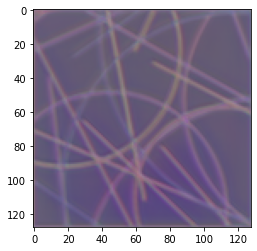

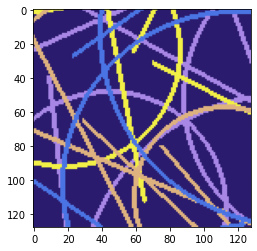

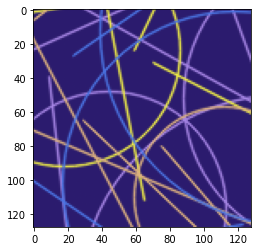

In [15]:
with torch.no_grad():
    input, labels, _ = next(iter(train_dataloader))
    input, labels = [x.to(device) for x in [input, labels]]
    output = net(input.to(device))
    #clear_output(wait=True)
    plt.figure()
    plt.imshow (preprocessor.denormalize_and_clip_as_numpy(output[0]))
    plt.figure()
    plt.imshow (preprocessor.denormalize_and_clip_as_numpy(labels[0]))
    plt.figure()
    plt.imshow (preprocessor.denormalize_and_clip_as_numpy(input[0]))